# Pre-workout

In [ ]:

from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from PIL import Image
import imghdr
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB7


target_shape = (256, 256)

In [ ]:
def clean_dataset(path):
    data_classes = [directory for directory in os.listdir(path) if os.path.isdir(path+directory)]

    for c, c_name in enumerate(data_classes):
        temp_path = os.path.join(path, c_name)
        temp_images = os.listdir(temp_path)

        for i in temp_images:
            img_tmp = os.path.join(temp_path, i)
            ext = imghdr.what(img_tmp)
           
            if ext not in ['jpeg', 'png']:
              os.remove(img_tmp)
              print(ext, img_tmp)
#clean_dataset('/content/drive/MyDrive/animals_dataset_the_ostriches/unbalanced_dataset_2304/validation/query/') PULITO
#clean_dataset('/datasets/animali/animals_dataset_the_ostriches/unbalanced_dataset_2304/training/')

In [ ]:
class Dataset(object):
    def __init__(self, data_path):
        #path of the dataset
        self.data_path = data_path

        #class list
        self.data_classes = [directory for directory in os.listdir(data_path) if os.path.isdir(data_path+directory)]

        # init lists and dictionary
        self.images = []
        self.labels = []
        self.class_names = {}

        print(data_path)

        # for each class and for each image save the image and the label in the lists 
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)
            self.class_names[c] = c_name

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.endswith('.jpg') or img_tmp.endswith('.JPEG') or img_tmp.endswith('.JPG') or img_tmp.endswith('.jpeg') :  
                  self.images.append(img_tmp)
                  self.labels.append(c)
                
                    

        print('Loaded {:d} images from {:s} '.format(len(self.images), self.data_path))

    def get_class_names(self):
      return self.class_names


    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)
    
    def get_dataset(self):
        names = tf.data.Dataset.from_tensor_slices(self.images)
        ds = names.map(self.preprocess_image)
        labels = tf.data.Dataset.from_tensor_slices(self.labels)
        return tf.data.Dataset.zip((names,ds,labels)).shuffle(buffer_size=1024).batch(1).prefetch(8)
    
    def get_images(self):
        
        return list(map(self.preprocess_image, self.images))

    def make_triplets(self):


      anchors = []
      positive = []
      negative = []
      
      

      for img, classe in zip(self.images, self.labels):
          #current image 
          currentImage = img
          anchors.append(currentImage)

          #positive image 
          pos_idx = self.get_random_image_idx_same_class(classe)
          pos_img = self.images[pos_idx]
          positive.append(pos_img)

          #negative imahe
          neg_idx = self.get_random_image_idx_different_class( classe)
          neg_img = self.images[neg_idx]
          negative.append(neg_img)

      a = tf.data.Dataset.from_tensor_slices(anchors)
      p = tf.data.Dataset.from_tensor_slices(positive)
      n = tf.data.Dataset.from_tensor_slices(negative)

      dataset = tf.data.Dataset.zip((a,p,n))
      image_count = len(dataset)

      dataset = dataset.shuffle(buffer_size=1024)
      dataset = dataset.map(self.preprocess_triplets)

      train_dataset = dataset.take(round(image_count * 0.8))
      val_dataset = dataset.skip(round(image_count * 0.8))

      train_dataset = train_dataset.batch(32).prefetch(8).cache()
      val_dataset = val_dataset.batch(32).prefetch(8).cache()

        
      return (train_dataset, val_dataset)



    def get_random_image_idx_same_class(self, classe):

        label = 'formaggio'

        while label != classe:
            idx = np.random.choice(len(self.images))
            label = self.labels[idx]
        
        return idx

    def get_random_image_idx_different_class(self, classe):

        label = classe

        while label == classe:
            idx = np.random.choice(len(self.images))
            label = self.labels[idx]
        return idx

    def preprocess_image(self, filename):
        """
        Load the specified file as a JPEG image, preprocess it and
        resize it to the target shape.
        """

      
        
        image_string = tf.io.read_file(filename)
        #image = tf.image.decode_jpeg(image_string, channels=1)
        image = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, target_shape)
        return image


    def preprocess_triplets(self,anchor, positive, negative):
        """
        Given the filenames corresponding to the three images, load and
        preprocess them.
        """
        try:
            a = self.preprocess_image(anchor),
            p = self.preprocess_image(positive),
            n = self.preprocess_image(negative),
        except:
          print('problemi')

        return (a,p,n)


      

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
     




In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [ ]:
def create_embedding():

    embedding = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape + (3,), include_top=False
    )

    

    trainable = False
    for layer in embedding.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    
    return embedding


In [ ]:
def create_embedding50():

    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape + (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    output = layers.Dense(512, activation="relu")(flatten)


    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    
    return embedding

In [ ]:
def create_embeddingB7():

    base_cnn = EfficientNetB7(
        weights="imagenet", input_shape=target_shape + (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    output = layers.Dense(128, activation="relu")(flatten)


    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    
    return embedding

In [ ]:
def create_embedding16():

    base_cnn = vgg16.VGG16(
        weights="imagenet", input_shape=target_shape + (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    output = layers.Dense(128, activation="relu")(flatten)


    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    
    return embedding

In [ ]:
# returns a dictionary with 
def calculate_results(query, gallery_embeddings, embedding):
    results = {} # results[image_name] = 0 if top1

    for query_item in query:
        sim = {} # dictionary sim[image_name] = euclidian distance

        # query label and embeddings
        query_name = bytes.decode(query_item[0].numpy()[0]) # from tensor to string
        query_emb = embedding(resnet.preprocess_input(query_item[1]))
        query_label= query_item[2].numpy()[0]

        # iterate all over the gallery and get the distance of each image
        for url, (emb, label) in gallery_embeddings.items():
            similarity = tf.norm(query_emb - emb, ord='euclidean')
            sim[url] = (float(similarity), label.numpy()[0])

        # sort the gallery
        sorted_gallery = list(sorted(sim.items(), key=lambda item: item[1]))[:16]

        # evaluate 

        for i in reversed(range(10)):
            if class_names_g[sorted_gallery[i][1][1]] == class_names_q[query_label]: # if query label is equal to the gallery label set to 1 
                results[query_name] = i
            
        
        if query_name not in results:
            results[query_name] = 11
    
    return results
       
    

   


In [ ]:
# we can use different embeddings like the resnet50-based or the vgg
def create_siamese(embedding):
    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))
    #embedding = create_embedding2()

    distances = DistanceLayer()(
        embedding(resnet.preprocess_input(anchor_input)),
        embedding(resnet.preprocess_input(positive_input)),
        embedding(resnet.preprocess_input(negative_input)),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], 
        outputs=distances
    )

    return siamese_network

In [ ]:
def create_gallery_embeddings(embedding, gallery):
    gallery_embeddings = {}
    for name, img, label in gallery:
        a = embedding(resnet.preprocess_input(img))
        url = bytes.decode(name[0].numpy())
        gallery_embeddings[url] = (a, label)
    return gallery_embeddings

In [ ]:
#TODP VGG

# Model

## Dataset

In [ ]:
training_path = '/datasets/animali/animals_dataset_the_ostriches/unbalanced_dataset_2304/training/'
stupid_path = '/content/drive/MyDrive/stupid dataset/'

In [ ]:
tr, val = Dataset(data_path = training_path).make_triplets()

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/animali/animals_dataset_the_ostriches/unbalanced_dataset_2304/training/'

## Define siamese model

In [ ]:
embedding = create_embedding()
siamese_network = create_siamese(embedding)
siamese_model50 = SiameseModel(siamese_network)

In [ ]:
embedding50 = create_embedding50()
siamese_network50 = create_siamese(embedding50)
siamese_model50 = SiameseModel(siamese_network50)


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
embedding16 = create_embedding16()
siamese_network16 = create_siamese(embedding16)
siamese_model16 = SiameseModel(siamese_network16)

In [ ]:
embeddingB7 = create_embeddingB7()
siamese_networkB7 = create_siamese(embeddingB7)
siamese_modelB7 = SiameseModel(siamese_networkB7)

In [ ]:
training = tr
validation = val.take(1)

## Train model

In [ ]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)


siamese_model.compile(optimizer=optimizers.Adam(0.001))
siamese_model.fit(training ,epochs=10,  callbacks=[cp_callback])

Epoch 1/10
 80/826 [=>............................] - ETA: 4:57:01 - loss: 0.7660

InvalidArgumentError: Graph execution error:

jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg_1}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_23969]

## Load Model

In [ ]:
checkpoint_path = "/datasets/animali/checkpoints/triplet50/lordi.cp"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_dir 

'/datasets/animali/checkpoints/triplet50'

In [ ]:

checkpoint_path = "/datasets/animali/checkpoints/triplet50/"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.listdir(checkpoint_dir)
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

siamese_model = SiameseModel(siamese_network50)

siamese_model.load_weights(latest)



# Evaluate

## Evaluate on test data 

### Test dataset

In [ ]:
gallery_path = '/datasets/animali/animals_dataset_the_ostriches/unbalanced_dataset_2304/validation/gallery/'
query_path = "/datasets/animali//animals_dataset_the_ostriches/unbalanced_dataset_2304/validation/query/"

gallery_path = '/datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/gallery/'
query_path = '/datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/query/'


gallery_ds = Dataset(data_path=gallery_path)
query_ds = Dataset(data_path=query_path)

gallery = gallery_ds.get_dataset()
query = query_ds.get_dataset()

class_names_g = gallery_ds.get_class_names()
class_names_q = query_ds.get_class_names()


it = iter(query)



/datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/gallery/
Loaded 4992 images from /datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/gallery/ 
/datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/query/
Loaded 100 images from /datasets/animali/animals_dataset_the_ostriches/animals_dataset/validation2/query/ 


### compute gallery embeddings 

In [ ]:
gallery_embedding = create_gallery_embeddings(embedding50, gallery.skip(1000).take(1000))
results = calculate_results(query, gallery_embedding, embedding50)
get_grouped_results(results)



NameError: name 'get_grouped_results' is not defined

In [ ]:
get_grouped_results(results)


68 23 28 32


model (male, top1,top3, top10) 

resnet50 no dense (65 15 25 35) no train 

resnet50 (64 19 27 36) dim 512 

resnet50 (52, 29, 42, 48) no train (68 23 28 32)

resnet50 (62, 15, 32, 48) 15 e 100 

vgg16 (55, 22, 28, 45) no train 

efficenteb7  (55, 26, 37, 45) no train 

In [ ]:
gallery_embedding = create_gallery_embeddings(embedding16, gallery.take(1000))
results = calculate_results(query, gallery_embedding, embedding16)
get_grouped_results(results)


55 22 28 45


In [ ]:
get_grouped_results(results)


55 22 28 45


In [ ]:
gallery_embedding = create_gallery_embeddings(embeddingB7, gallery.take(1000))
results = calculate_results(query, gallery_embedding, embeddingB7)
get_grouped_results(results)


55 26 37 45


In [ ]:
gallery_embedding16 = create_gallery_embeddings(embedding16, gallery.take(1000))

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
gallery_embeddingB7 = create_gallery_embeddings(embeddingB7, gallery.take(1000))

In [ ]:
len(gallery_embeddings)

369

### new query image

Text(0.5, 1.0, 'mouse')

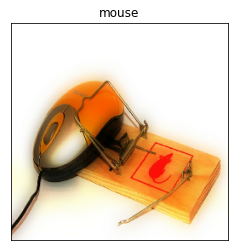

In [ ]:

query_item = next(it)

plt.xticks([])
plt.yticks([])
plt.imshow(query_item[1][0], cmap=plt.cm.binary)
plt.grid(False)
plt.title(class_names_q[query_item[2].numpy()[0]])




In [ ]:
query_item[2].numpy()[0]

0

In [ ]:
results50 = calculate_results(query, gallery_embedding50, embedding50)
results16 = calculate_results(query, gallery_embedding16, embedding16)
resultsB7 = calculate_results(query, gallery_embeddingB7, embeddingB7)




In [ ]:
get_grouped_results(results50)
get_grouped_results(results16)
get_grouped_results(resultsB7)

74 14 22 26
77 12 17 23
71 13 23 29


In [ ]:
def get_grouped_results(results):
    male = 0
    top1 = 0
    top3 = 0
    top10 = 0

    for key, value in results.items():
        if value > 10:
            male += 1
        if value < 10:
            top10+=1
        if value < 3:
            top3+=1
        if value == 0:
            top1+=1
        
        
    print(male, top1, top3, top10)
  

### Visualize query image

### Visualize sorted gallery

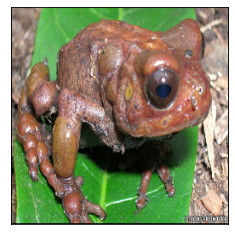

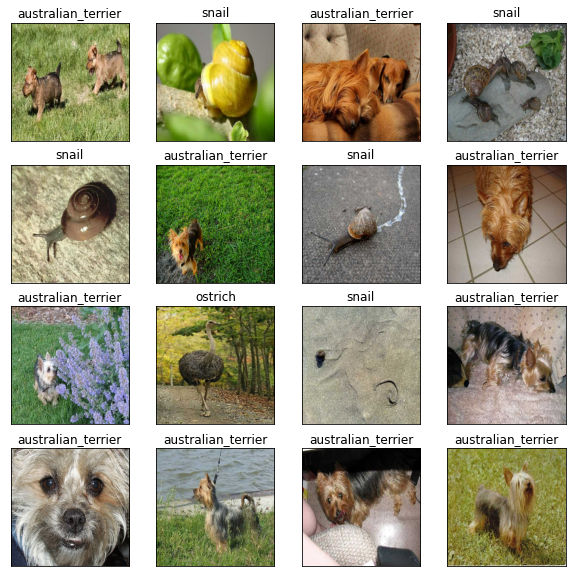

In [ ]:
plt.xticks([])
plt.yticks([])
plt.imshow(query_item[1][0], cmap=plt.cm.binary)
plt.grid(False)

plt.figure(figsize=(10,10))
for i, (path, simi) in enumerate(sorted_gallery):
    plt.subplot(4,4,i+1)
    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap=plt.cm.binary)
    plt.grid(False)
    plt.title(class_names_g[simi[1]] )#+ round(simi[0],2)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93aceac2-8452-469e-8b02-c16d0438aa9c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>